# Using IIR filters

In the previous section, we saw the general definition of IIR filters.
In this section, we'll see how to use them in practice, and begin to probe at understanding their behavior by testing their outputs in response to synthetic input signals.

As in the previous chapter, we'll focus on low-pass filters, but the ideas will readily generalize to other settings.

In [13]:
%run ../setup.ipynb

## IIR filters in Python

In the previous section, we defined a function {ref}`filter <iir-function>` that implements {eq}`iir`.
Given an input signal $x$ and filter coefficients `b` (feed-forward) and `a` (feed-back), we construct the output signal $y$ one sample at a time, using nested loops in a manner not too different from (time-domain) convolution.

In practice, we would do better to use an existing implementation and not write our own from scratch.
Luckily, the `scipy.signal` package provides exactly this function: [`lfilter`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html) (linear filter).

For example, the exponential moving average filter could be implemented as follows:

```{code-block} python
import scipy.signal

b = [1/2]  # Feed-forward
a = [1, -1/2]  # Feed-back

# Apply the filter to input signal x
y = scipy.signal.lfilter(b, a, x)
```

We can use this, for example, to compute the first few samples of the impulse response:

In [20]:
# Compute the first few samples of the impulse response
# of an exponential moving average

x = np.array([1, 0, 0, 0, 0, 0, 0])
y = scipy.signal.lfilter([1/2], [1, -1/2], x)
print(y)

[0.5       0.25      0.125     0.0625    0.03125   0.015625  0.0078125]


## Example: Butterworth filters

The first type of filter that we'll look at is called the *Butterworth filter*, after Stephen Butterworth {cite}`butterworth1930theory`.
We'll not get into the details of how the filter coefficients are defined, but instead rely on the `scipy.signal.butter` function to construct them for us.

Using `scipy.signal.butter` is not too different from using the window-method function `firwin` to design an FIR low-pass filter.
We'll need to supply the *order* of the filter, as well as the cutoff frequency $f_c$ and the sampling rate.
The example code below constructs an order-10 filter with $f_c = 500$ Hz and $f_S = 44100$.

In [355]:
fs = 44100  # Sampling rate
fc = 500  # Cutoff frequency

# Build the low-pass filter
b, a = scipy.signal.butter(10, fc, fs=fs)

# Print the coefficients
print('Feed-forward: ', b)
print('Feed-back:    ', a)

Feed-forward:  [2.62867578e-15 2.62867578e-14 1.18290410e-13 3.15441093e-13
 5.52021913e-13 6.62426296e-13 5.52021913e-13 3.15441093e-13
 1.18290410e-13 2.62867578e-14 2.62867578e-15]
Feed-back:     [   1.           -9.54462136   41.00487909 -104.41737082  174.53480697
 -200.09486144  159.34094444  -87.02835847   31.2004603    -6.6300023
    0.6341236 ]


To demonstrate the filter's behavior, let's apply it to a 250-sample delayed impulse, padded with zeros out to 1000 samples.
There's nothing special about the particular delay that we're using, but it will allow us to compare the magnitude and phase spectra before and after applying the filter.
Remember that impulses (including delayed impulses) have energy at all frequencies, so this should give us a sense of how well the filter works at attenuating high frequencies.
By default, the `lfilter` function produces an output $y$ of the same length as the input, which might not capture all of the response behavior that we want to look at.
Padding the input with trailing zeros gives us time to observe more of the response without truncating prematurely.

````{margin}
```{warning}
In this section, we're investigating the behavior of an IIR filter by analyzing a finite bit of its output in response to a particular input signal.
This should not be confused with analyzing the filter directly!
We'll see how to do that in the next chapter.
```
````

In [356]:
# Create the delayed impulse signal
x = np.zeros(1000)
x[249] = 1

# Apply the Butterworth filter from above
y = scipy.signal.lfilter(b, a, x)

We can now inspect the DFT of the input $x$ and output $y$ to see what the filter has done: the results are illustrated in {numref}`butter`.

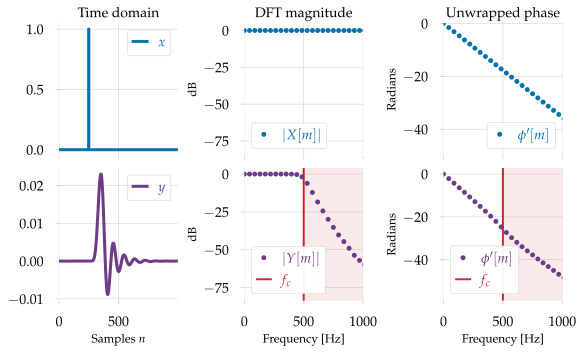

In [375]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex='col', figsize=figaspect(0.6))

X = np.fft.rfft(x)
Y = np.fft.rfft(y)

freqs = np.fft.rfftfreq(len(x), 1/fs)

axes[0, 0].step(np.arange(len(x)), x, where='post', label='$x$')
axes[0, 0].label_outer()
axes[0, 0].legend(loc='upper right', labelcolor='linecolor')

axes[1, 0].step(np.arange(len(y)), y, where='post', label='$y$', color=colors[4])
axes[1, 0].label_outer()
axes[1, 0].set(xlabel='Samples $n$')
axes[1, 0].legend(loc='upper right', labelcolor='linecolor')

axes[0, 1].plot(freqs, 20 * np.log10(np.abs(X) + 1e-4), linestyle='', marker='.', label='$|X[m]|$')
axes[0, 1].set(ylim=[-85, 5])
axes[0, 1].set(ylabel='dB')

axes[0, 1].legend(loc='lower left', labelcolor='linecolor')

axes[1, 1].plot(freqs, 20 * np.log10(np.abs(Y) + 1e-4), linestyle='', marker='.', label='$|Y[m]|$', color=colors[4])
axes[1, 1].axvline(500, color=colors[1], zorder=-1, label='$f_c$', linewidth=2)
axes[1, 1].axvspan(500, freqs[-1], color=colors[1], zorder=-2, alpha=0.1)


axes[1, 1].set(xlabel='Frequency [Hz]')
axes[1, 1].set(ylabel='dB')
axes[1, 1].legend(loc='lower left', labelcolor='linecolor')

axes[0, 2].plot(freqs, np.unwrap(np.angle(X)), linestyle='', marker='.', label=r"$\phi'[m]$")
axes[0, 2].set(ylabel="Radians")
axes[0, 2].legend(loc='lower right', labelcolor='linecolor')

axes[1, 2].plot(freqs, np.unwrap(np.angle(Y)), linestyle='', marker='.', label=r"$\phi'[m]$", color=colors[4])
axes[1, 2].axvline(500, color=colors[1], zorder=-1, label='$f_c$', linewidth=2)
axes[1, 2].axvspan(500, freqs[-1], color=colors[1], zorder=-2, alpha=0.1)
axes[1, 2].legend(loc='lower left', labelcolor='linecolor')
axes[1, 2].set(xlabel='Frequency [Hz]')
axes[1, 2].set(ylabel="Radians")
axes[1, 2].set(xlim=[0, 1000])
axes[1, 1].set(xlim=[0, 1000])
axes[0, 0].set(title='Time domain')
axes[0, 1].set(title='DFT magnitude')
axes[0, 2].set(title='Unwrapped phase')
axes[0, 2].set(ylim=[-50, 0.1])

glue('butter', fig, display=False)

```{glue:figure} butter
**Top-left**: a 250-sample delay signal $x$, padded with zeros to 1000 samples.
**Top-center**: the magnitude spectrum $|X|$, measured in decibels, zoomed into the frequency range $[0, 1000]$.
**Top-right**: the unwrapped phase spectrum $\phi'$ of $x$.
**Bottom-left**: the output $y$ after applying an order-10 low-pass Butterworth filter with cutoff $f_c=500$.
**Bottom-center**: the magnitude spectrum $|Y|$, with stop-band marked by the shaded region.
**Bottom-right**: the unwrapped phase spectrum $\phi'$ of $y$.
```

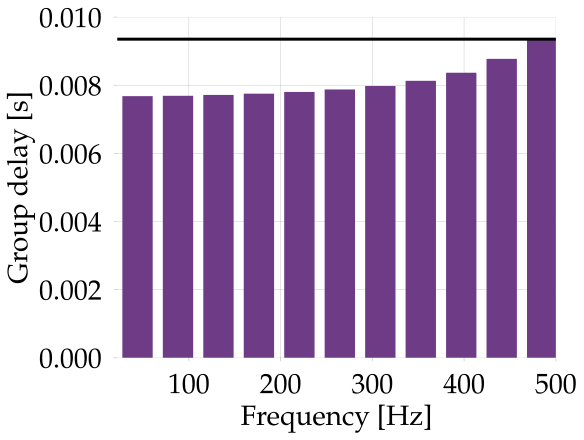

In [370]:
with plt.rc_context({'font.size': 28, 'xtick.labelsize': 28, 'ytick.labelsize': 28, 'axes.labelsize': 28}):
    fig, ax = plt.subplots(figsize=figaspect(.75))

    G = np.diff(np.unwrap(np.angle(Y))) / (-2 * np.pi) * N / fs

    ax.bar(freqs[1:], G, color=colors[4], label=r"$\phi'$", width=0.75 * fs/N)
    ax.set(xlim=[freqs[1]//2, 500], ylim=[0, 0.01])
    ax.axhline(G[10], color='k')
    ax.set(xlabel='Frequency [Hz]', ylabel='Group delay [s]')
    glue('phase-zoom', fig, display=False)

````{margin}
```{glue:figure} phase-zoom
:name: buttergd

A more careful look at the group delay of $y$ within the passband shows that the delay is not constant over all frequencies, especially near the cutoff $f_c=500$.
```
````

We can immediately observe a couple of interesting things in {numref}`butter`, especially when compared to the FIR filters demonstrated in {numref}`firwin` and {numref}`pmfir`.
First, the time-domain output $y$ is delayed relative to the input---it peaks much later---with asymmetric ripples that decay to 0.

Second, even though the filter has only order 10, its stop-band attenuation is comparable to the FIR filters, which have much higher order (in the hundreds)!

Third, the phase response looks *approximately* linear in the pass-band, but it turns out to not be *exactly* linear.
As a result, different frequencies present in $x$ have been delayed by slightly different amounts to create $y$, which we perhaps could have anticipated from the fact that $x$ is symmetric in time (after padding) but $y$ is asymmetric.

These observations point to general features of IIR filters (not just Butterworth): they can be much more efficient than FIR filters, but they rarely have linear phase.
Applying them naively can lead to phase distortion artifacts.

## Selecting the order

In the example above, the choice of order 10 might seem arbitrary, but it was in fact chosen to satisfy certain criteria: no more than 3dB pass-band ripple, 60 dB of stop-band attenuation, and a transition band from 500 to 1000 Hz.
The `scipy` helper function `scipy.signal.buttord` takes these parameters, and provides the minimal filter order which satisfies the constraints:

```{code-block} python
fc = 500  # Cutoff at 500 Hz
fstop = 1000  # End the transition band at 1000 Hz
passband_ripple = 3  # 3dB ripple
stopband_atten = 60  # 60 dB attenuation of the stop-band

# Get the smallest order for the filter
order = scipy.signal.buttord(fc, fstop, passband_ripple, stopband_atten, fs=fs)

# Now construct the filter
b, a = scipy.signal.butter(order, fc, fs=fs)
```

If you recall how {ref}`parks-mcclellan` optimizes the filter coefficients subject to constraints on ripple, attenuation, and transition bandwidth, the idea is very similar here (although the underlying optimization is quite different).
In general, when using IIR filters, it's a good idea to look for helper functions (like order selection) which can help you determine the best settings to satisfy your constraints.

## Compensating for phase distortion

The example above illustrates two things: 1) that IIR filters induce delay, just like FIR filters, and 2) IIR filters are often not linear-phase, resulting in phase distortion (see margin {numref}`buttergd`).

There is a nice trick for dealing with both of these issues: filter the signal twice, but in opposite directions!
More specifically, we do the following:

1. Apply the filter once: `y1 = filter(b, a, x)`
2. Let `y1_rev` be `y1` in reverse order: `y1_rev = y1[::-1]`
3. Apply the filter again: `y2_rev = filter(b, a, y1_rev)`
4. Reverse again to obtain the final output: `y = y2_rev[::-1]`

The key idea here is that if filtering the signal once (forward in time) induces some delay, then filtering it again in the opposite direction (backward in time) should undo that delay exactly.
This even works if the delay is different for each frequency, so even if a filter has non-linear phase, we can undo any distortion artifacts.  **Awesome!**

There are two caveats to be aware of.

````{margin}
```{tip}
If you plan to use double-filtering, design your filters to have half the target gain!
That is, if you want your total stop-band attenuation to be 80dB, design your filter to achieve 40dB.
```
````
1. Any gain that would be applied by the filter will be applied *twice*.  If a frequency is attenuated by 40 dB in one pass, it will be attenuated by 80 dB in two passes.  This also goes for gain and pass-band ripple, not just stop-band attenuation.  
2. Double-filtering can only be applied if we can observe the entire input signal in advance: it is **non-causal**! This is fine for pre-recorded signals, but cannot work for real-time audio streams.

Caveats aside, this technique is so common that it is also provided by most signal processing frameworks.
In `scipy`, it is called `scipy.signal.filtfilt`, and we can use it just like we would use `lfilter`.
The example below illustrates how to apply this method to our example signal and low-pass filter, with results illustrated in {numref}`butter2`.

In [364]:
fs = 44100  # Sampling rate
fc = 500  # Cutoff frequency

# Build the low-pass filter for double-filtering
# This means we'll cut the pass-band ripple and stop-band attenuation both in half
# We only need the first output from buttord
order, _ = scipy.signal.buttord(fc, 1000, 3/2, 60/2, fs=fs)

b2, a2 = scipy.signal.butter(order, fc, fs=fs)

# Apply the double filter
y2 = scipy.signal.filtfilt(b2, a2, x)

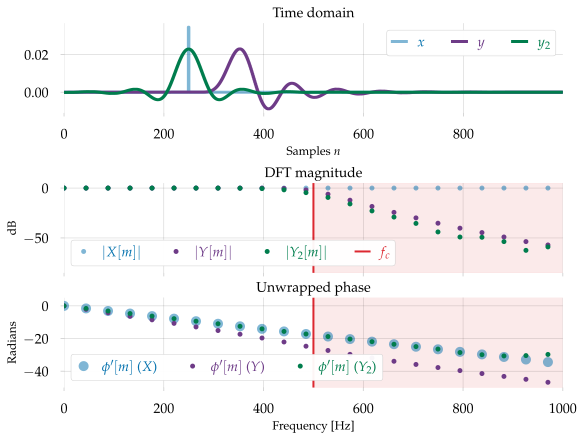

In [374]:
fig, axes = plt.subplots(nrows=3, figsize=figaspect(0.75))

X = np.fft.rfft(x)
Y = np.fft.rfft(y)
Y2 = np.fft.rfft(y2)

freqs = np.fft.rfftfreq(len(x), 1/fs)

axes[0].step(np.arange(len(x)), x * y.max() * 1.5, where='post', label='$x$', alpha=0.5)
axes[0].step(np.arange(len(y)), y, where='post', label='$y$', color=colors[4])
axes[0].step(np.arange(len(y2)), y2, where='post', label='$y_2$', color=colors[5])
axes[0].set(xlabel='Samples $n$')
axes[0].legend(loc='upper right', labelcolor='linecolor', ncol=3)

axes[1].plot(freqs, 20 * np.log10(np.abs(X) + 1e-4), linestyle='', marker='.', label='$|X[m]|$', alpha=0.5)
axes[1].set(ylim=[-85, 5])
axes[1].set(ylabel='dB')
axes[1].plot(freqs, 20 * np.log10(np.abs(Y) + 1e-4), linestyle='', marker='.', label='$|Y[m]|$', color=colors[4])
axes[1].plot(freqs, 20 * np.log10(np.abs(Y2) + 1e-4), linestyle='', marker='.', label='$|Y_2[m]|$', color=colors[5])
axes[1].set(xlabel='Frequency [Hz]')
axes[1].set(ylabel='dB')
axes[1].label_outer()
axes[1].axvline(500, color=colors[1], zorder=-1, label='$f_c$', linewidth=2)
axes[1].axvspan(500, freqs[-1], color=colors[1], zorder=-2, alpha=0.1)
axes[1].legend(loc='lower left', labelcolor='linecolor', ncol=4)

axes[2].plot(freqs, np.unwrap(np.angle(X)), linestyle='', marker='o', zorder=-1, label=r"$\phi'[m]$ ($X$)", alpha=0.5)
axes[2].set(ylabel="Radians")
axes[2].plot(freqs, np.unwrap(np.angle(Y)), linestyle='', marker='.', label=r"$\phi'[m]$ ($Y$)", color=colors[4])
axes[2].plot(freqs, np.unwrap(np.angle(Y2)), linestyle='', marker='.', label=r"$\phi'[m]$ ($Y_2$)", color=colors[5])
axes[2].axvline(500, color=colors[1], zorder=-1, linewidth=2)
axes[2].axvspan(500, freqs[-1], color=colors[1], zorder=-2, alpha=0.1)
axes[2].set(xlabel='Frequency [Hz]')
axes[2].set(ylabel="Radians")
axes[2].legend(loc='lower left', labelcolor='linecolor', ncol=4)
axes[2].set(xlim=[0, 1000])
axes[1].set(xlim=[0, 1000])
axes[2].set(ylim=[-50, 5])
axes[0].set(title='Time domain')
axes[1].set(title='DFT magnitude')
axes[2].set(title='Unwrapped phase')


glue('butter2', fig, display=False)

```{glue:figure} butter2
:name: butter2

**Top**: the input signal $x$ (an impulse delayed by 250 samples), along with the single-pass output $y$ (order=10) and the double-pass output $y_2$ (order=6).
**Middle**: the DFT magnitudes of $X$ (constant), $Y$, and $Y_2$.
**Bottom**: the unwrapped phase of $X$, $Y$, and $Y_2$.
Note that the phase of $Y_2$ agrees with $X$ over the pass-band, indicating a total delay of 0.
```

{numref}`butter2` illustrates that the double-filtering approach does effectively align the final output $y_2$ to the input $x$: their time-domain representations peak in exactly the same position.
Note, however, that reverse-filtering does introduce *pre-echo*: the oscillations in $y_2$ preceding the peak at $n=249$.
In this respect, the result is similar to the FIR filter outputs in {numref}`pmfir`, and is to some extent unavoidable if we're applying low-pass filtering to signals with strong transients.
Remember: although the outputs are similar, we got there with much less work: an order-6 IIR filter applied twice, compares well to FIR filters with order in the hundreds!

Butterworth filters are just the beginning: in the next section, we'll meet a few more types of IIR filters.